### Below used for debugging individual circuit runs


In [1]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric, TotalSwaps
from transpile_benchy.metrics.timer import TimeMetric
from mirror_gates.fast_unitary import FastConsolidateBlocks
from qiskit.transpiler.passes import Collect2qBlocks, Unroll3qOrMore, ConsolidateBlocks
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger

In [2]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qv_n8 from QiskitCircuitInterface


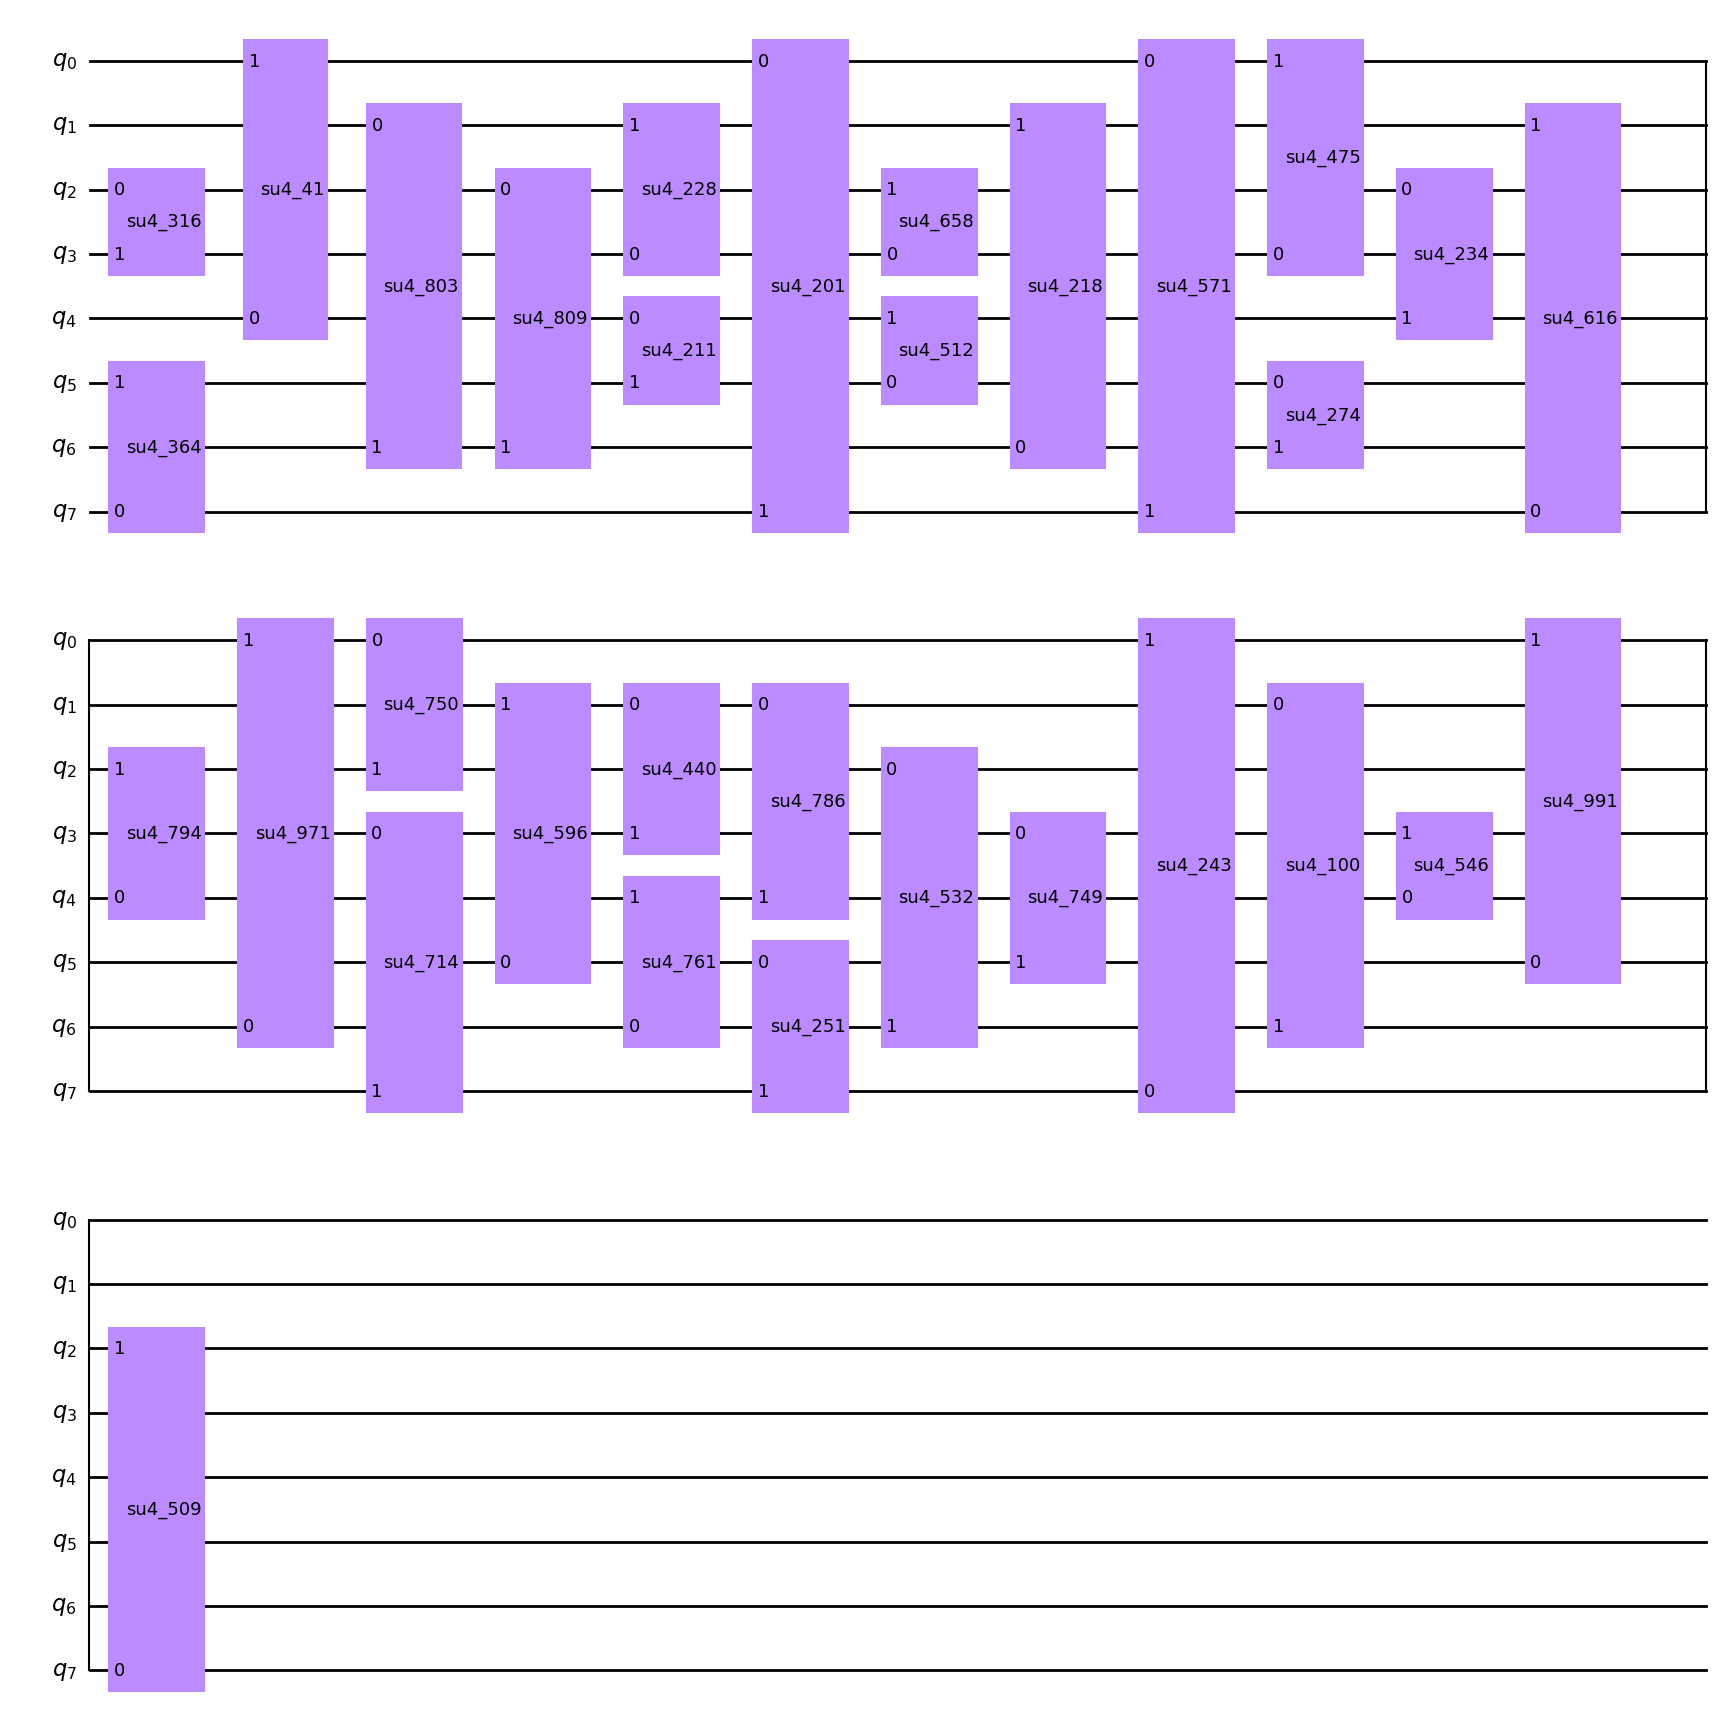

In [3]:
from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_txt("../circuits/debug.txt")
qc = lib.get_circuit("qv_n8")
display(qc.decompose().draw("mpl"))

26.5
67.5
24


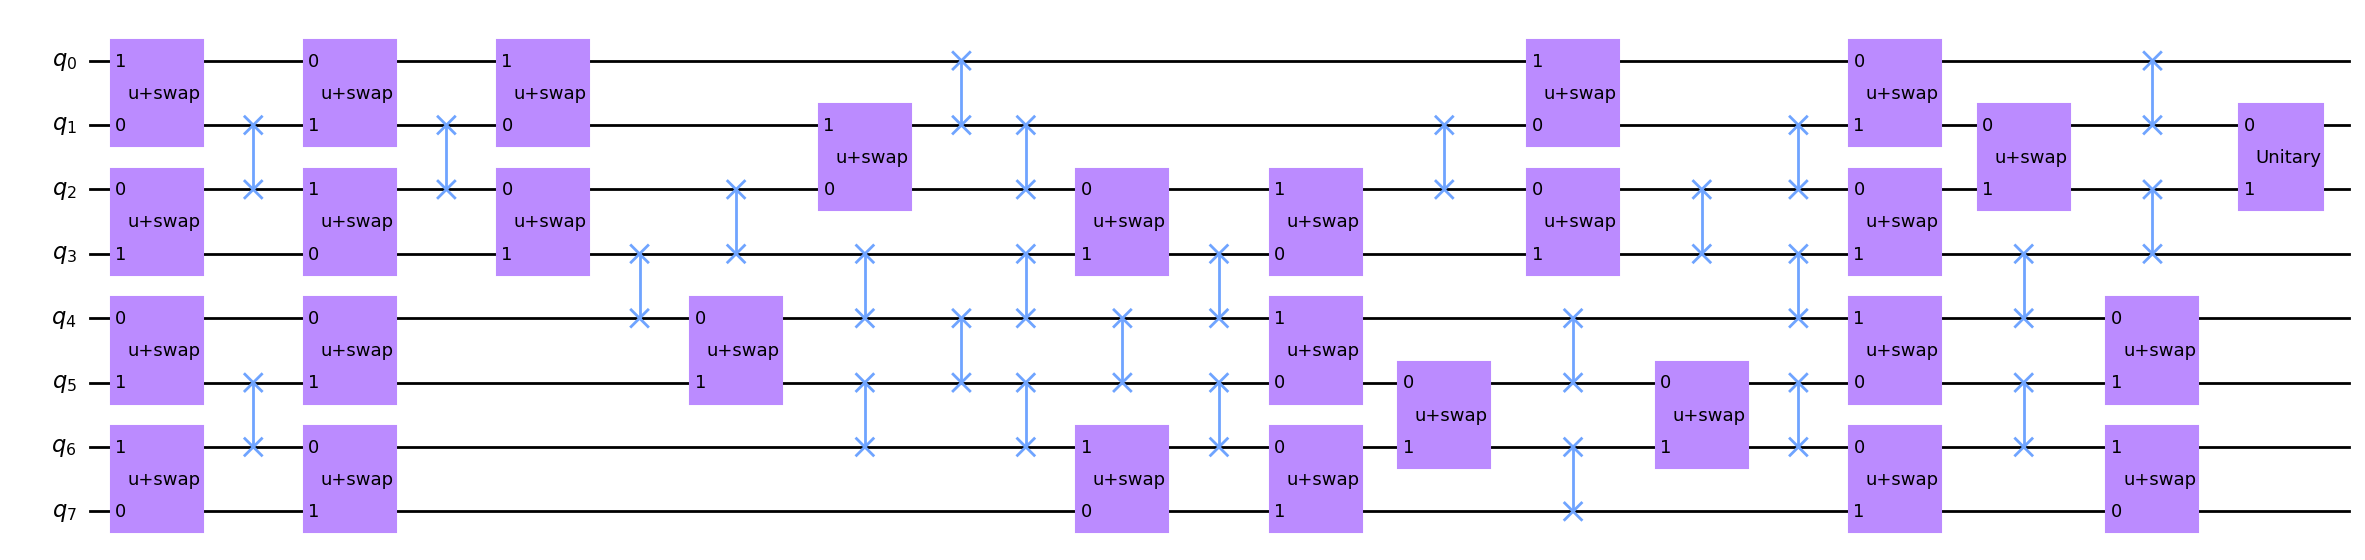

In [11]:
runner = SabreMS(
    coupling_map,
    cx_basis=0,
    # parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=5,
    fb_iters=16,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
)

runner.seed = 0
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
# metric = TimeMetric()
# runner._append_metric_pass(metric)

transp = runner.run(qc)
# print(runner.property_set["accepted_subs"])
print(runner.property_set["monodromy_depth"])
print(runner.property_set["monodromy_total"])
print(runner.property_set["total_swaps"])
display(runner.property_set["mid"].draw("mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))
# display(transp.draw(output="mpl", fold=-1))

26.0
20


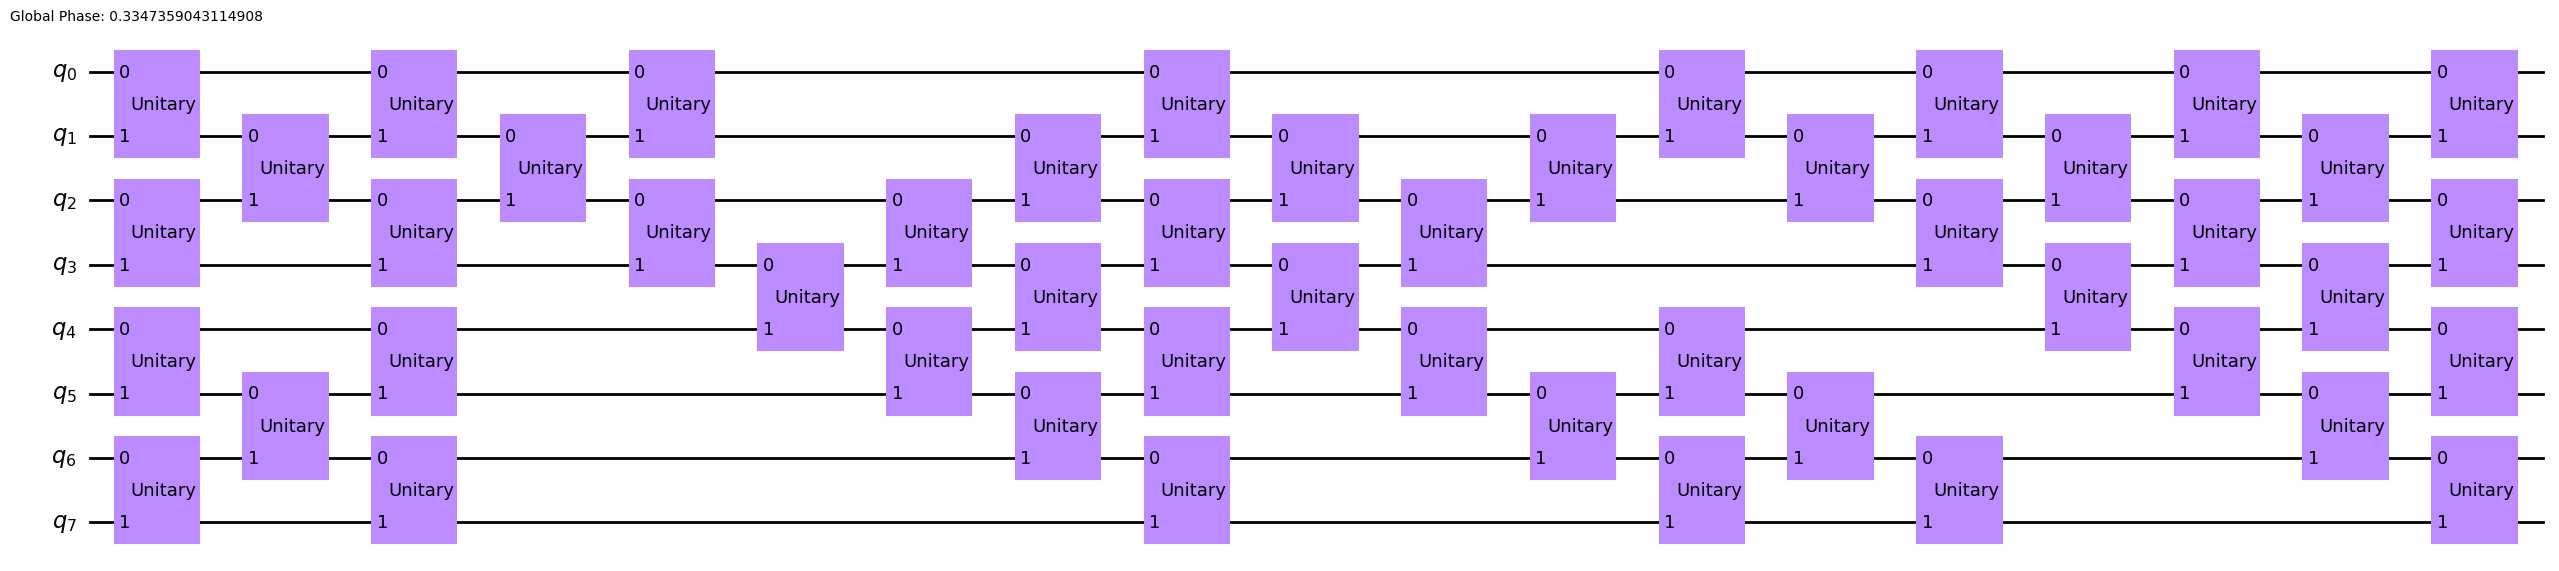

In [7]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["monodromy_depth"])
print(runner.property_set["total_swaps"])
# print(runner.property_set["monodromy_total"])
display(transp.draw(output="mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))